# Setup

## Imports

In [23]:
# Basic Libraries
import warnings
import pandas as pd
import numpy as np

# EDA
import sweetviz as sv
from skimpy import skim, clean_columns
from klib import convert_datatypes
from klib import describe
from dython import nominal

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## Configurations and Functions

In [24]:
# Defining plot standard parameters
plt.rcParams.update({
    "axes.labelcolor": "#595959",
    "axes.facecolor": (0, 0, 0, 0),
    "axes.grid": False,
    "axes.labelpad": 6,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (9.25, 2.5),
    "figure.facecolor": (0, 0, 0, 0),
    "figure.dpi": 100,
    "legend.edgecolor": "#D9D9D9",
    "legend.borderaxespad": 0,
    "legend.framealpha": None,
    "legend.fontsize": 8,
    "legend.loc": "upper right",
    "legend.title_fontsize": 9,
    "text.color": "#595959",
    "xtick.color": "#D9D9D9",
    "xtick.labelcolor": "#595959",
    "ytick.color": "#D9D9D9",
    "ytick.labelcolor": "#595959"
})

In [25]:
def plot_bar_over_time(df_for_plot, col, ylabel, dpi=200, format_as_currency=False):
    # Creating Figure
    fig, ax = plt.subplots(dpi=dpi)
    # Plotting Axes
    ax.bar(x=df_for_plot.index, height=col, data=df_for_plot, width=20)  # Adjust the width parameter as needed
    # Setting Ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Adjust the interval as needed
    fig.autofmt_xdate(rotation=0, ha="center")  # Auto format date labels
    # Labeling
    ax.set_ylabel(ylabel=ylabel, loc="top")
    for container in ax.containers:
        if format_as_currency:
            labels = [f"R$ {bar.get_height():,.2f}" for bar in container]
        else:
            labels = [f"{bar.get_height():.0f}" for bar in container]
        ax.bar_label(container, labels=labels, label_type="edge", color="#1f77b4", size=10)
    # Setting Labels Aesthetics
    ax.spines["bottom"].set_color("#D9D9D9")
    ax.spines["left"].set_color("#D9D9D9")

    return ax

In [26]:
def plot_distribution(data, xlabel, dpi=200):
    """
    """
    with sns.plotting_context(rc={
        "axes.facecolor":(0,0,0,0), 
        "figure.facecolor":(0,0,0,0), 
        "figure.dpi": dpi
    }):
        # Getting Stats
        mean = data.mean().item()
        std = data.std().item()
        median = data.median().item()
        skew = data.skew().item()
        kurtosis = data.kurtosis().item()
        # Setting Parameters
        rug_kws = ({"color": "#ff3333", "alpha": 0.15, "lw": 3, "height": 0.1})
        kde_kws = ({"alpha": 0.75, "linewidth": 1.5, "bw_adjust": 1.5})  # Increased bw_adjust to 1.5
        # Creating FacetGrid
        grid = sns.displot(
            data,
            kind="kde",
            rug=True,
            legend=False,
            height=2.5,
            aspect=3.7,
            rug_kws=rug_kws,
            **kde_kws,
        );
        # Filling quantile range
        x, y = grid.ax.lines[0].get_xydata().T
        grid.ax.fill_between(
            x,
            y,
            where=(
                (x >= np.quantile(data, 0.025))
                & (x <= np.quantile(data, 0.975))
            ),
            label=f"{0.025*100:.1f}% - {0.975*100:.1f}%",
            color="#80d4ff",
            alpha=0.2
        )
        # Creating Lines
        grid.ax.vlines(
            x=mean,
            ymin=0,
            ymax=np.interp(mean, x, y),
            ls="dotted",
            color="orange",
            lw=2,
            label="média",
        )
        grid.ax.vlines(
            x=median,
            ymin=0,
            ymax=np.interp(median, x, y),
            ls=":",
            color=".3",
            label="mediana",
        )
        grid.ax.vlines(
            x=[mean - std, mean + std],
            ymin=0,
            ymax=[np.interp(mean - std, x, y), np.interp(mean + std, x, y)],
            ls=":",
            color=".5",
            label="\u03BC \u00B1 \u03C3",
        )

        # Positioning plot on customized limits
        grid.ax.set_ylim(0)
        grid.ax.set_xlim(
            grid.ax.get_xlim()[0] - grid.ax.get_xlim()[1] * 0.05, grid.ax.get_xlim()[1] * 1.03,
        )
        # Annotations and legend
        grid.ax.text(0.01, 0.9, f"Média: {mean:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.8, f"Mediana: {median:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.7, f"Desv Pad: {std:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.6, f"Skew: {skew:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.5, f"Kurtosis: {kurtosis:.2f}", transform=grid.ax.transAxes,)
        grid.ax.text(0.01, 0.4, f"Contagem: {len(data)}",  transform=grid.ax.transAxes,)
        # Setting Labels Aesthetics
        grid.ax.legend(loc="upper right", fontsize=9)
        grid.despine(left=True)
        grid.ax.spines["bottom"].set_color("#D9D9D9")
        grid.ax.set_ylabel(None)
        grid.ax.get_yaxis().set_visible(False)
        grid.ax.set_xlabel(xlabel)

        return grid

# Ingesting Data

In [27]:
# Ingesting data
df = (
    clean_columns(
        df=convert_datatypes(
            data=(
                pd.read_csv(
                    filepath_or_buffer="../data/raw/report.csv",
                    usecols=(
                        "Order",
                        "Client Hash",
                        "Creation Date",
                        "UF",
                        "City",
                        "UtmSource",
                        "Coupon",
                        "Total Value",
                    ),
                    delimiter=";",
                    parse_dates=["Creation Date"],
                )
            ),
            cat_threshold=0.5
        )
        .dropna(subset="Client Hash"),
        case="snake"
    )
)

df.to_csv(path_or_buf="../data/processed/report.csv", index=False)

# Overall Reports

In [28]:
# # Sweetviz
# with warnings.catch_warnings():  # Ignoring pandas future warnings of SweetViz
#     warnings.filterwarnings("ignore")
#     sv_eda_report = sv.analyze(source=df)
# sv_eda_report.show_html(filepath="../reports/report.html", layout="vertical")

In [29]:
# # Skimpy
# skim(df.drop(columns="creation_date"))

# Exploration

## Order Centric

In [30]:
df_agg_by_order = df.groupby("order").agg({
    "creation_date": "first",
    "uf": "first",
    "city": "first",
    "utm_source": "first",
    "coupon": "first",
    "total_value": "first",
    "client_hash": "first",
    "order": "size"
}).rename(columns={"order": "distinct_itens"}).reset_index()

display(df_agg_by_order)

,order,creation_date,uf,city,utm_source,coupon,total_value,client_hash,distinct_itens
0,1443721354657-01,2024-07-01 00:43:06+00:00,SP,Santo André,google,True,120.489998,78d7fce822b85c7a5619bbd821b51632,1
1,1443721354659-01,2024-07-01 00:52:17+00:00,SP,Santos,bio,False,210.139999,34880fbe711610d808c31838b3aa6ad4,1
2,1443721354661-01,2024-07-01 01:04:13+00:00,RJ,Rio de Janeiro,google,False,786.210022,68761cc97c4566da33aad819b7455632,5
3,1443721354663-01,2024-07-01 01:22:03+00:00,RJ,Petrópolis,google,True,122.589996,49a5edecedf8fc91ad287bec38571b8c,1
4,1443731354665-01,2024-07-01 01:50:39+00:00,SP,São Paulo,bio,False,360.880005,e5122c8d7455b9fe8b175c91151084bf,2
...,...,...,...,...,...,...,...,...,...
6619,NMD-56581bd473ae412e8ae89926f8884c15,2024-09-15 19:26:41+00:00,SP,Guararapes,NaN,False,196.330002,8b808a0c72d801c97b4c08301e4e2179,1
6620,NMD-9b6578aad4464b858ed33e8d8205a342,2024-07-01 13:51:08+00:00,SP,Sao Paulo,NaN,False,69.269997,6731701b2bcc888f2b4790ba1bcc7f4e,1
6621,NTS-125364206,2024-07-17 02:02:39+00:00,SC,PENHA,NaN,False,209.770004,7d416686bb86e61a6c47a93d0a0275f9,1
6622,NTS-126964782,2024-08-24 22:50:20+00:00,SP,SAO CAETANO DO SUL,NaN,False,219.500000,431c80617aced896dce5f628bdf5c1ba,2


/Users/ewerthon/Library/Caches/pypoetry/virtualenvs/ml-rfm-clustering-E0X7KYVB-py3.12/lib/python3.12/site-packages/dython/nominal.py:187: RuntimeWarning: Rounded V = 1.0000000000000198 to 1.0. This is probably due to floating point precision issues.
  warnings.warn(
/Users/ewerthon/Library/Caches/pypoetry/virtualenvs/ml-rfm-clustering-E0X7KYVB-py3.12/lib/python3.12/site-packages/dython/nominal.py:187: RuntimeWarning: Rounded V = 1.0000000000000013 to 1.0. This is probably due to floating point precision issues.
  warnings.warn(


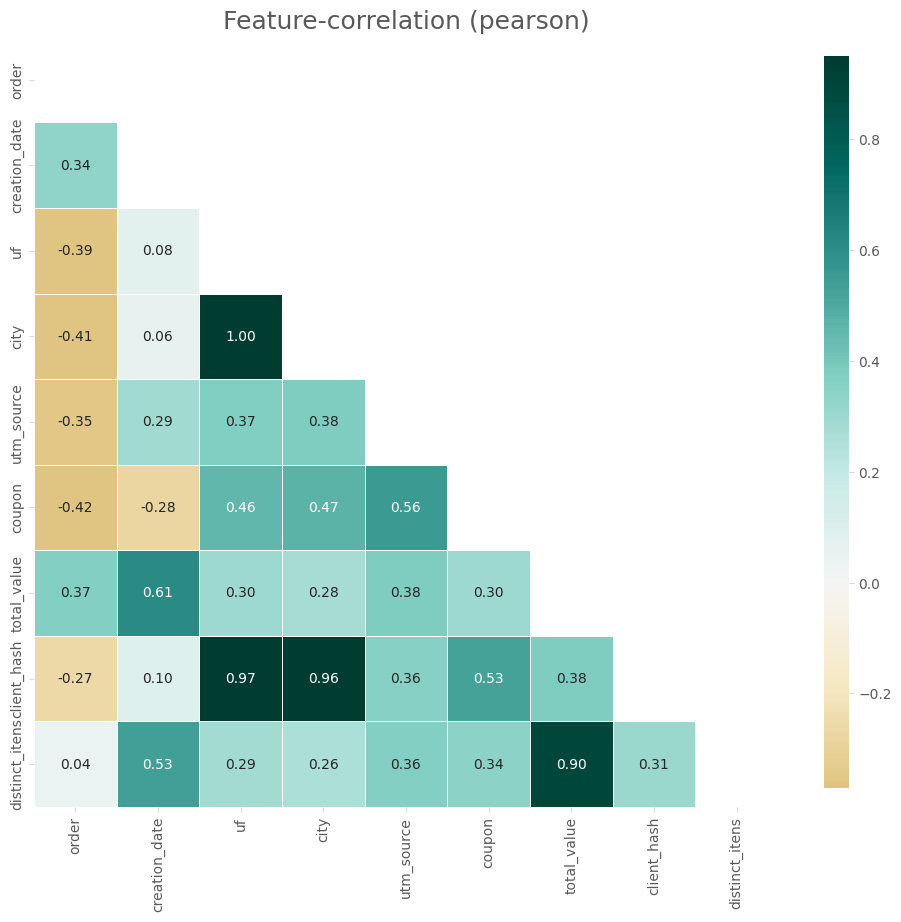

In [31]:
describe.corr_plot(
    data=nominal.associations(
        dataset=df_agg_by_order,
        nominal_columns=[
            "uf",
            "city",
            "utm_source",
            "coupon",
        ],
        numerical_columns=[
            "total_value",
            "distinct_itens"
        ],
        nom_nom_assoc="cramer",
        num_num_assoc="spearman",
        nom_num_assoc="correlation_ratio",
        nan_strategy="replace",
        nan_replace_value="null",
        cramers_v_bias_correction=False,
        compute_only=True
    )["corr"]
);

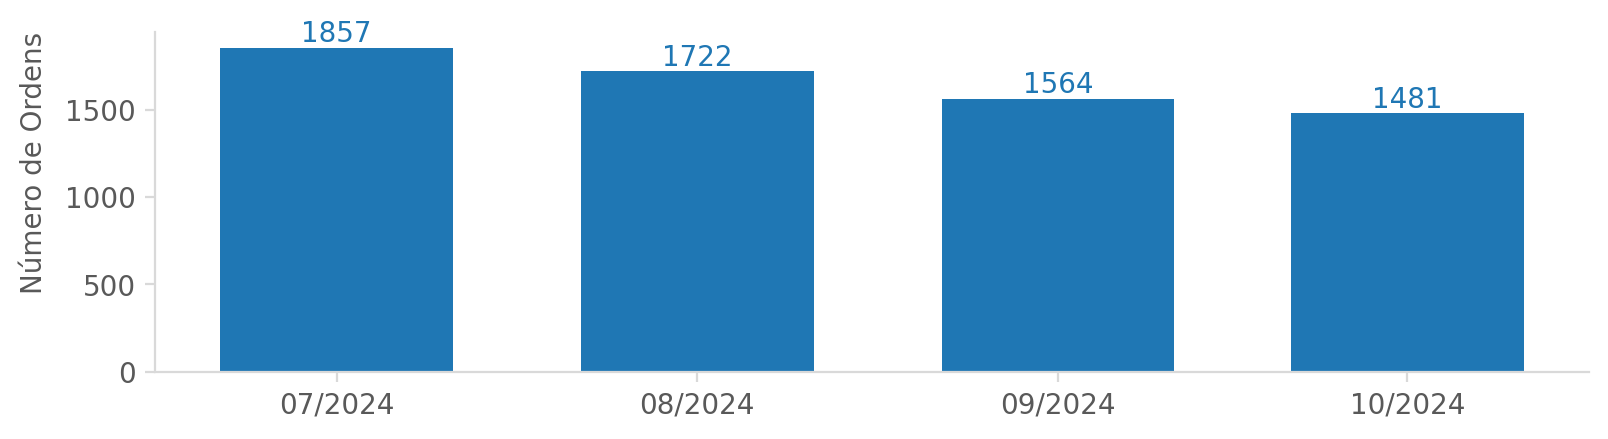

In [32]:
df_for_plot = (
    df_agg_by_order[["creation_date", "order"]]
    .set_index("creation_date")
    .sort_index()
    .resample("MS")
    .count()
)

plot_bar_over_time(
    df_for_plot=df_for_plot, 
    col="order", 
    ylabel="Número de Ordens",
    format_as_currency=False,
);


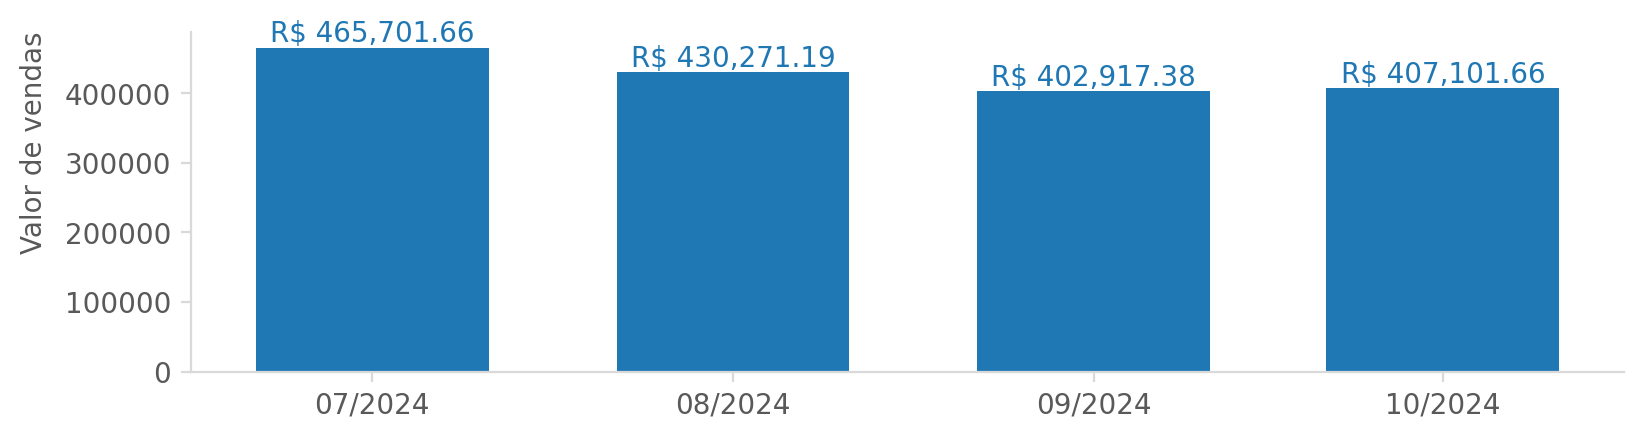

In [33]:
df_for_plot = (
    df_agg_by_order[["creation_date", "total_value"]]
    .set_index("creation_date")
    .sort_index()
    .resample("MS")
    .sum()
)

plot_bar_over_time(
    df_for_plot=df_for_plot, 
    col="total_value", 
    ylabel="Valor de vendas",
    format_as_currency=True,
);

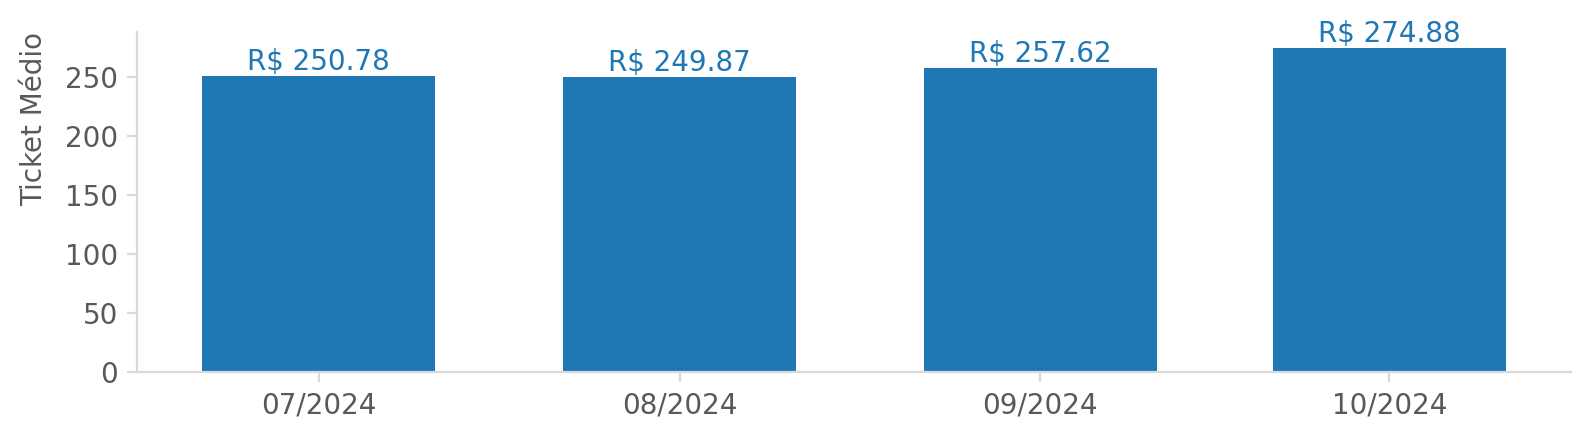

In [34]:
df_for_plot = (
    df_agg_by_order[["creation_date", "total_value"]]
    .set_index("creation_date")
    .sort_index()
    .resample("MS")
    .mean()
)

plot_bar_over_time(
    df_for_plot=df_for_plot, 
    col="total_value", 
    ylabel="Ticket Médio",
    format_as_currency=True,
);

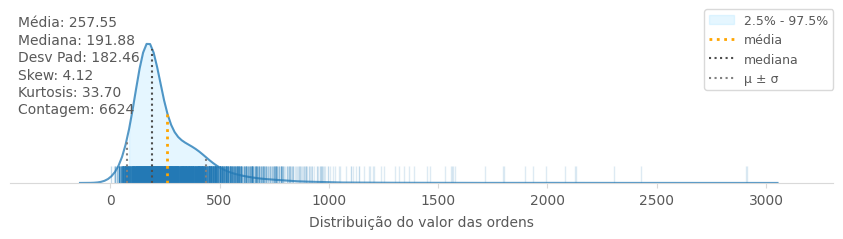

In [35]:
df_for_plot = df_agg_by_order["total_value"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição do valor das ordens",
);

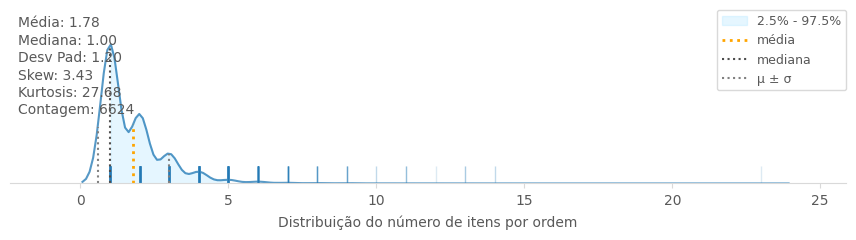

In [36]:
df_for_plot = df_agg_by_order["distinct_itens"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição do número de itens por ordem",
);

## User Centric

In [37]:
df_agg_by_user = (
    df_agg_by_order
    .groupby(
        by="client_hash",
        observed=True,
    )
    .agg(
        recency=pd.NamedAgg(column="creation_date", aggfunc=lambda x: (pd.Timestamp.now(tz="America/Sao_Paulo") - x.max()).days),
        frequency=pd.NamedAgg(column="order", aggfunc="count"),
        monetary=pd.NamedAgg(column="total_value", aggfunc="sum")
    )
    .reset_index()
)
display(df_agg_by_user)

,client_hash,recency,frequency,monetary
0,000ddc7194944726a759d4371ed2ed7e,70,1,134.880005
1,0026b85ecb79a4113fb2bce363dd8fc6,92,1,1532.880005
2,00337908e72cf6d232c900d4c8b69602,72,1,425.880005
3,003ef499ba8b5b72a2a67c591af7f411,82,1,191.350006
4,004974614c048fe7b3f6030287583cb4,69,1,140.880005
...,...,...,...,...
5526,ffbe0237f3c8fd13fc7b850f1044193b,10,1,920.880005
5527,ffcd29d860e336fbed9aa6f61088184a,92,1,480.000000
5528,ffcf6f5581f97ddada178f071d1fc7f9,6,6,504.399994
5529,ffd1e438f9d12989d557d743107b7280,98,1,201.399994


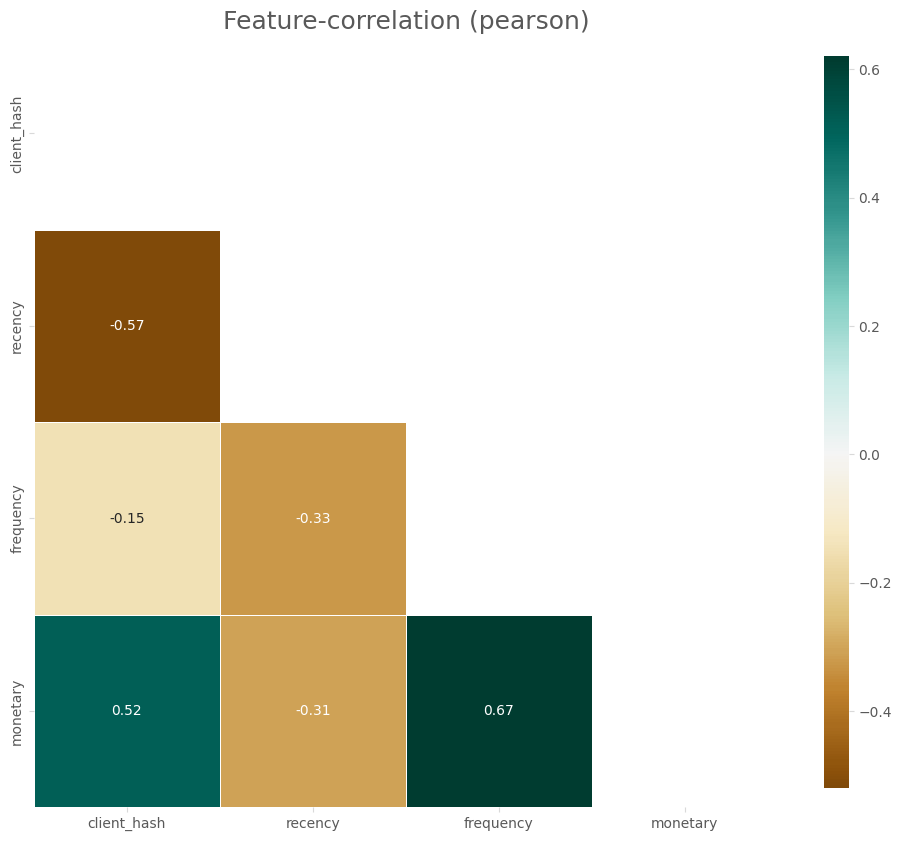

In [38]:
describe.corr_plot(
    data=nominal.associations(
        dataset=df_agg_by_user,
        numerical_columns=[
            "recency",
            "frequency",
            "monetary"
        ],
        nom_nom_assoc="cramer",
        num_num_assoc="spearman",
        nom_num_assoc="correlation_ratio",
        nan_strategy="replace",
        nan_replace_value="null",
        cramers_v_bias_correction=False,
        compute_only=True
    )["corr"]
);

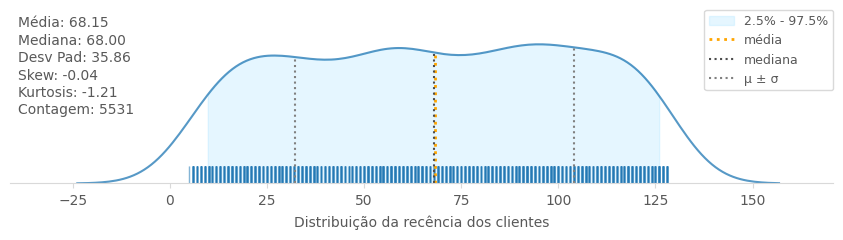

In [39]:
df_for_plot = df_agg_by_user["recency"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição da recência dos clientes",
);

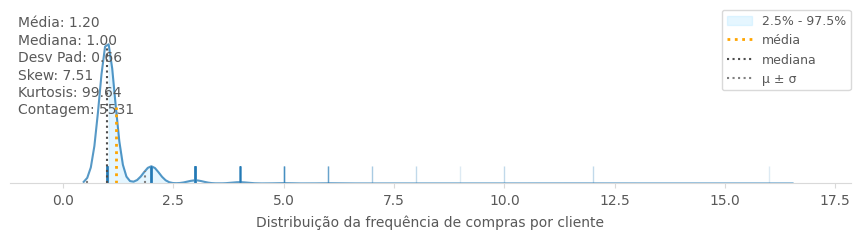

In [40]:
df_for_plot = df_agg_by_user["frequency"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição da frequência de compras por cliente",
);

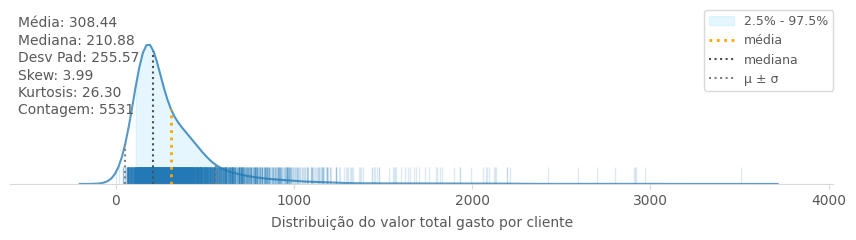

In [41]:
df_for_plot = df_agg_by_user["monetary"]

plot_distribution(
    data=df_for_plot, 
    xlabel="Distribuição do valor total gasto por cliente",
);

# Insights

## Centrado em Ordens
- A origem do cliente está correlacionada com o valor total da ordem.
- Determinadas cidades estão correlacionadas com o uso de cupons.
- O número de ordens vem caindo ao longo do tempo.
- O total de valor de vendas também diminuiu ao longo do período.
- O ticket médio subiu. Isso indica uma mudança no perfil das compras.
- O período não capta a sazonalidade do ano todo e isso pode ser comum.
- É bastante comum ordens terem mais de um item. Isso apresenta potencial para explorar aplicação de sistemas de recomendação no negócio.

## Centrado nos Usuários
- A recência de compras é muito bem distribuída, se aproximando de uma distribuição uniforme.
- A frequência de compra geral dos clientes é baixa (mediana = 1 e média =1).
- Há 5531 clientes distintos para 6624 ordens no período - corroborando com a baixa frequência de compra.
- A distribuição de gasto por cliente é mais variada e apresenta um desvio padrão alto quando comparado com a média (desvio = 255 e média 308).

## Overall
- É necessário observar um período maior com as sazonalidades ao longo do ano para concluir se o negócio é fortemente dependente de novos clientes para crescer ou se existem períodos de maior concentração de compras. Isso pode determinar qual a abordagem mais estratégica o negócio pode tomar.
- A dimensão de recência é a mais impactada negativamente para uma boa delimitação na segmentação, já que é mais concentrada em torno de 1.
- Quase todas as distribuições são próximas do formato normal com cauda longa e skewness positivo (assimetria positiva).
- Com uma base relativamente pequena de clientes, vale à pena abordar os outliers mais diretamente (como os clientes que realizaram mais de 5 compras nos 4 meses e/ou gastaram R$ 1.000,00). A correlação do cliente com o valor total também aponta para isso.